# agar.aio Score Analytics

**Jacob Sampson**

The following notebook analyzes the performance of an agent trained with the NEAT algorithm against agents with basic functionality, including 'greedy', 'aggressive', and 'defensive' agents.

In [1]:
import pandas as pd

scores = pd.read_csv('../checkpoints/scores.csv')

In [2]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   checkpoint  1505 non-null   object
 1   run         1505 non-null   int64 
 2   score       1505 non-null   int64 
 3   player      1505 non-null   object
dtypes: int64(2), object(2)
memory usage: 47.2+ KB


In [3]:
# Convert 'checkpoint' to integer (checkpoint-n)
scores['checkpoint'] = scores['checkpoint'].apply(lambda x: int(x.split('-')[1]))

In [4]:
scores['score'].describe()

count    1505.000000
mean       34.184718
std        13.886667
min         0.000000
25%        36.000000
50%        36.000000
75%        38.000000
max       121.000000
Name: score, dtype: float64

In [5]:
scores.groupby('player')['score'] \
    .agg(['mean']) \
    .sort_values('mean', ascending=False)

,mean
player,
NN,35.418421
AGGRESSIVE,34.106101
GREEDY,33.801061
DEFENSIVE,33.390836


In [6]:
scores.groupby('player')['score'] \
    .agg(['mean']) \
    .sort_values('mean', ascending=False) / scores[(scores['player'] == 'DEFENSIVE')]['score'].mean()

,mean
player,
NN,1.060723
AGGRESSIVE,1.021421
GREEDY,1.012286
DEFENSIVE,1.000000


We can see the agent trained with the NEAT algorithm performs the best on average with the defensive agent performing the worst.

Text(0, 0.5, '')

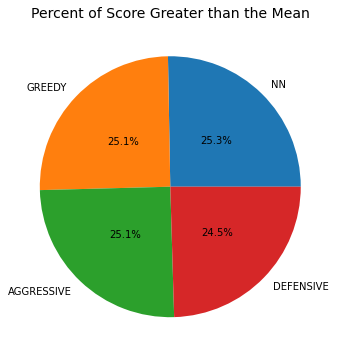

In [7]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=[10,6])
scores[scores['score'] > scores['score'].mean()]['player'] \
    .value_counts() \
    .plot.pie(autopct="%.1f%%", ax=ax, pctdistance=0.5)
plt.title(
    'Percent of Score Greater than the Mean',
    fontsize=14
)
plt.ylabel('') # Remove 'player' annotation

Text(0, 0.5, '')

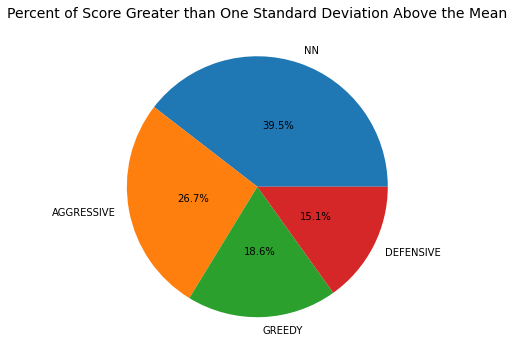

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(figsize=[10,6])
scores[scores['score'] > (scores['score'].mean() + scores['score'].std())]['player'] \
    .value_counts() \
    .plot.pie(autopct="%.1f%%", ax=ax, pctdistance=0.5)
plt.title(
    'Percent of Score Greater than One Standard Deviation Above the Mean',
    fontsize=14
)
plt.ylabel('') # Remove 'player' annotation

Text(0, 0.5, '')

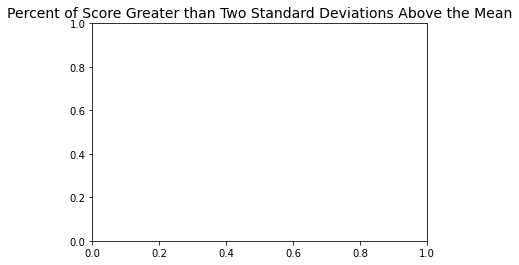

In [9]:
scores[scores['score'] > (scores['score'].mean() + 2 * scores['score'].std())]['player'] \
    .value_counts() \
    .plot.pie(autopct="%.1f%%", ax=ax, pctdistance=0.5)
plt.title(
    'Percent of Score Greater than Two Standard Deviations Above the Mean',
    fontsize=14
)
plt.ylabel('') # Remove 'player' annotation

Text(0.5, 0, 'Player')

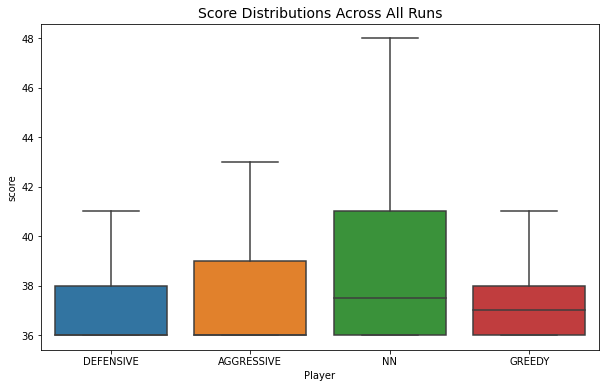

In [10]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=[10,6])
sns.boxplot(
    data=scores[['player', 'score']].query('score > 0'),
    y='score',
    x='player',
    showfliers=False
)
plt.title(
    'Score Distributions Across All Runs',
    fontsize=14
)
plt.xlabel('Player')

The agent trained with NEAT has the largest percentage of high-performing sessions

<AxesSubplot:xlabel='score', ylabel='Count'>

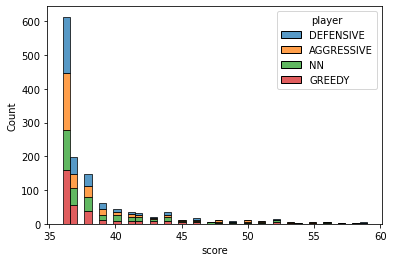

In [11]:
# Plot without '0'
# plt.rcParams['figure.figsize'] = [15, 15]
sns.histplot(
    data=scores[['player', 'score']][(scores['score'] > 0) & (scores['score'] <  60)],
    x='score',
    hue='player',
    multiple="stack",
)

Text(0.5, 1.0, 'Percent of Score Equal to Zero')

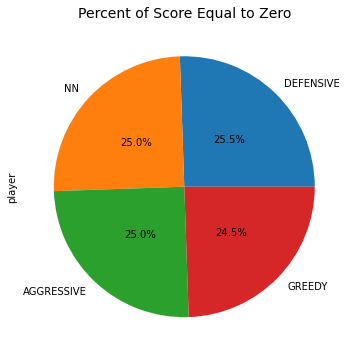

In [12]:
_, ax = plt.subplots(figsize=[10,6])
scores[scores['score'] == 0]['player'] \
    .value_counts() \
    .plot.pie(autopct="%.1f%%", ax=ax, pctdistance=0.5)
plt.title(
    'Percent of Score Equal to Zero',
    fontsize=14
)

Text(0.5, 0, 'Checkpoint')

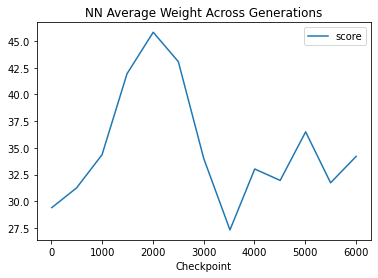

In [13]:
scores[scores['player'] == 'NN'].drop(columns=['run']) \
    .groupby('checkpoint') \
    .mean() \
    .plot()
plt.title('NN Average Weight Across Generations')
plt.xlabel('Checkpoint')

In [14]:
scores[scores['player'] == 'NN'].drop(columns=['run']) \
        .groupby('checkpoint') \
        .mean()

,score
checkpoint,
8,29.416667
496,31.258065
998,34.363636
1490,41.933333
2006,45.810811
2501,43.062500
3002,34.000000
3518,27.333333
4006,33.027778


Text(0.5, 0, 'Checkpoint')

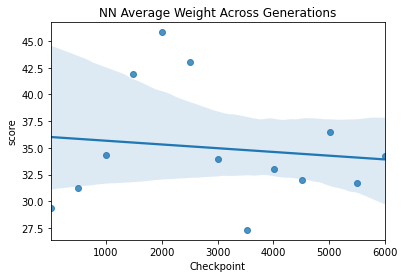

In [15]:
import numpy as np

scores_nn = scores[scores['player'] == 'NN'].drop(columns=['run']) \
        .groupby('checkpoint') \
        .mean()
scores_nn = pd.DataFrame(
    np.array([scores_nn.index.values, scores_nn.values.flatten()]).T,
    columns=['checkpoint', 'score']
)
sns.regplot(
    data=scores_nn,
    x='checkpoint',
    y='score'
)
plt.title('NN Average Weight Across Generations')
plt.xlabel('Checkpoint')

Text(0, 0.5, 'Average Score (Across 50 Runs)')

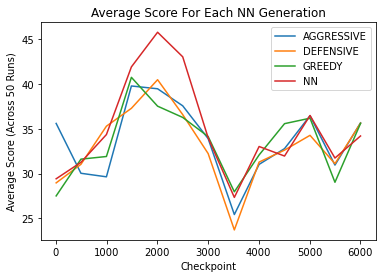

In [16]:
scores_mean = scores.drop(columns='run') \
    .groupby(['checkpoint', 'player']) \
    .mean() \
    .unstack()
scores_mean.plot()
plt.title('Average Score For Each NN Generation')
plt.legend(list(map(lambda x: x[1], scores_mean.columns)))
plt.xlabel('Checkpoint')
plt.ylabel('Average Score (Across 50 Runs)')

Text(0, 0.5, 'Average Score (Across 50 Runs)')

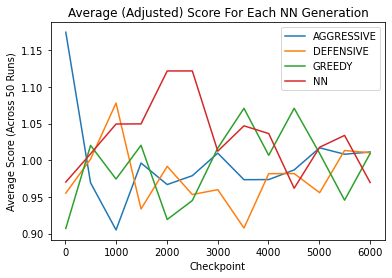

In [17]:
filtered_scores = scores.copy()

# Adjust scores by average for each checkpoint
scores_checkpoints = filtered_scores.drop(columns=['run']) \
        .groupby('checkpoint')['score'] \
        .mean()
scores_checkpoints = pd.DataFrame(
    np.array([scores_checkpoints.index.values, scores_checkpoints.values.flatten()]).T,
    columns=['checkpoint', 'avg_score']
)

adjusted_scores = scores.copy()
adjusted_scores['score'] = filtered_scores['score'] / filtered_scores.merge(scores_checkpoints, on='checkpoint', how='outer')['avg_score']
adjusted_scores

scores_mean = adjusted_scores.drop(columns='run') \
    .groupby(['checkpoint', 'player']) \
    .mean() \
    .unstack()
scores_mean.plot()
plt.title('Average (Adjusted) Score For Each NN Generation')
plt.legend(list(map(lambda x: x[1], scores_mean.columns)))
plt.xlabel('Checkpoint')
plt.ylabel('Average Score (Across 50 Runs)')

In [18]:

deaths = scores.query('score == 0').groupby('checkpoint').count().unstack()['score']
deaths_checkpoints = pd.DataFrame(
    np.array([deaths.index.values, deaths.values.flatten()]).T,
    columns=['checkpoint', 'deaths']
)

,checkpoint,AGGRESSIVE,DEFENSIVE,GREEDY,NN,deaths
count,13.000000,11.000000,12.000000,12.000000,11.000000,13.000000
mean,3003.461538,0.253305,0.318336,0.305668,0.247781,14.153846
std,1949.542152,0.057152,0.220191,0.225490,0.052517,10.073448
min,8.000000,0.142857,0.166667,0.166667,0.166667,1.000000
25%,1490.000000,0.236111,0.229348,0.200000,0.219807,6.000000
50%,3002.000000,0.266667,0.263768,0.241546,0.260870,11.000000
75%,4507.000000,0.286364,0.297619,0.297619,0.279221,23.000000
max,6004.000000,0.333333,1.000000,1.000000,0.333333,30.000000


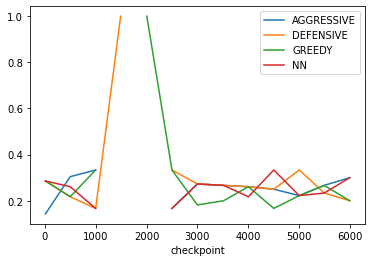

In [19]:
deaths_combined = scores.query('score == 0').groupby(['checkpoint', 'player'])['score'] \
    .count().unstack().merge(deaths_checkpoints, on='checkpoint')
deaths_combined['AGGRESSIVE'] = deaths_combined['AGGRESSIVE'] / deaths_combined['deaths']
deaths_combined['DEFENSIVE'] = deaths_combined['DEFENSIVE'] / deaths_combined['deaths']
deaths_combined['NN'] = deaths_combined['NN'] / deaths_combined['deaths']
deaths_combined['GREEDY'] = deaths_combined['GREEDY'] / deaths_combined['deaths']
deaths_combined.drop(columns=['deaths']).plot(x='checkpoint')
deaths_combined.describe()

Text(0.5, 0, 'Checkpoint')

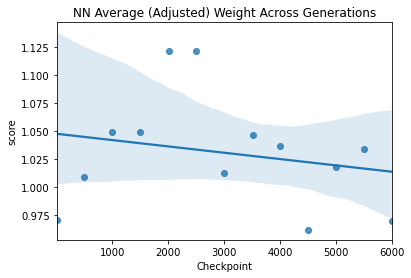

In [20]:
import numpy as np

scores_nn = adjusted_scores[adjusted_scores['player'] == 'NN'].drop(columns=['run']) \
        .groupby('checkpoint') \
        .mean()
scores_nn = pd.DataFrame(
    np.array([scores_nn.index.values, scores_nn.values.flatten()]).T,
    columns=['checkpoint', 'score']
)
sns.regplot(
    data=scores_nn,
    x='checkpoint',
    y='score'
)
plt.title('NN Average (Adjusted) Weight Across Generations')
plt.xlabel('Checkpoint')